# NAIVE BAYES SPAM FILTER #

## CMSC 197, Problem Set 2 ##

Submitted to: Ms. Ara Abigail E. Ambita <br>
Submitted by: Alyssa Alexandra S. Lee

In [1]:
##### Standard Libraries #####
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
##### For preprocessing #####
import os 
import re
import email 
import codecs
##### For performance evaluation #####
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score

**Preprocessing**

First, we will initialize the main dataframe. The columns that are included are folder where the email is located, the email's filename, email message, and classification if ham or spam. Note: 0 if ham and 1 if spam.

In [2]:
df = pd.DataFrame(columns = ['folder', 'file', 'email_message', 'classification'])
df

,folder,file,email_message,classification


Next, we will initialize the Labels dataframe.

In [4]:
#Path to labels 
labels_path = "trec06/labels"
df_labels = pd.read_csv("trec06/labels", sep = " ", header = None)
#Columns of the dataframe
df_labels.columns = ["classification", "filepath"]
#Change ham to 0 and spam to 1
df_labels["classification"] = df_labels["classification"].apply(lambda kv: 0 if kv == "ham" else 1)
#Get rid of "../data/" from filepath
df_labels["filepath"] = df_labels["filepath"].apply(lambda kv: kv.replace("../data/", ""))
df_labels

,classification,filepath
0,0,000/000
1,1,000/001
2,1,000/002
3,0,000/003
4,1,000/004
...,...,...
37817,1,126/017
37818,1,126/018
37819,1,126/019
37820,1,126/020


In [5]:
#LIST THE FOLDERS IN THE DATA DIRECTORY

folder_path = "trec06/data"
#Create variable called folders
folders = os.listdir(folder_path)
folders

['000',
 '001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',


In [6]:
#Punctuation marks
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~\\"
#Numbers
num = "0123456789"
#Escape characters
esc = re.compile(r'\\[a-z][a-z]?[0-9]+')
#HTML tags
tags = re.compile('<.*?>') 
#List of information found in the email that will be dropped
stop_words = []
#Get the stop words
with open('stop_words.txt', 'r') as file:
    stop_word = file.read().splitlines()
    stop_words = [word for word in stop_word]

In [7]:
#NECESSARY FUNCTIONS

#Function in dropping useless information found in the email
def drop_info(msg):
    #One of the most common preprocessing steps where the text is converted into the same case
    #Since stop words are in lowercase, we'll convert everything to lowercase
    msg = msg.lower()
    #Remove HTML tags
    msg = re.sub(tags, '', msg)
    #Remove punctuation marks
    msg = msg.translate(str.maketrans('', '', punc))
    #Remove numbers
    msg = msg.translate(str.maketrans('', '', num))
    #Remove escape characters
    msg = re.sub(esc, '', repr(msg))
    #Convert raw string to have unicode escape characters
    msg = codecs.decode(msg, 'unicode_escape')
    #Splits msg (string) into a list of words
    words = msg.split()
    #Remove stop words or meaningless words
    words = [word for word in words if word not in stop_words]
    #Joins the words into one string, msg
    msg = " ".join(words)
    msg = msg.strip("'")
    return msg

#Function to get message from parsed email
def get_msg(parsed):
    msg = ""
    #If it is a multipart email,
    if parsed.is_multipart():
        #Iterate over parts of the email
        for part in parsed.walk():
            #If the content type of the part is text/plain,
            if part.get_content_type() == 'text/plain':
                #Get the message
                msg = part.get_payload()
                break
    #Otherwise, just get the message
    else:
        msg = parsed.get_payload()
    return msg

*_Preprocessing of the Entire Trec06 Dataset_*

Each email will be preprocessed in a standard character set which is ISO-8859-1 and unnecessary information will be removed.

In [8]:
#Read each email and place them in a dataframe
for folder in folders:
    #Get the files inside the folder
    files = os.listdir(f"{folder_path}/{folder}")
    for file in files:
        with open(f"{folder_path}/{folder}/{file}", "r", encoding = "ISO-8859-1") as e_mail:
            read_email_file = e_mail.read()
            parsed = email.message_from_string(read_email_file)
            msg = get_msg(parsed)
            msg = drop_info(msg)
            #Get the classification of the email based on the Labels dataframe
            labels_classification = df_labels[df_labels['filepath'] == f"{folder}/{file}"]['classification'].values[0]
            #Concatenate the data to the main dataframe
            df = pd.concat([df, pd.DataFrame([[folder, file, msg, labels_classification]], columns = ["folder", "file", "email_message", "classification"])], ignore_index = True)
df

,folder,file,email_message,classification
0,000,000,the mailing list queried weeks ago running set...,0
1,000,001,luxury watches buy rolex rolex cartier bvlgar...,1
2,000,002,academic qualifications prestigious nonacc red...,1
3,000,003,greetings verify subscription planfans list ch...,0
4,000,004,try chauncey conferred luscious continued tons...,1
...,...,...,...,...
37817,126,017,great news expec ted infinex ventures infx pri...,1
37818,126,018,the oil sector going crazy weekly gift kkpt th...,1
37819,126,019,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,020,u prosperous future increased money earning po...,1


Let us create a folder containing preprocessed files and save the main dataframe as preprocessed_emails.csv.

In [9]:
if not os.path.exists('preprocessed_files'):
    os.makedirs('preprocessed_files')
df.to_csv("preprocessed_files/preprocessed_emails.csv", index = False)
#Reset the main dataframe for memory overload to not occur
df.drop(df.index, inplace = True)
df = pd.DataFrame(columns = ["folder", "file", "email_message", "classification"])
df

,folder,file,email_message,classification


*_Importing the Preprocessed Data_*

In [12]:
df2 = pd.read_csv("./preprocessed_files/preprocessed_emails.csv")

#SPLIT DATASET INTO TRAINING SET FOR HAM, TRAINING SET FOR SPAM, AND THE TESTING SET

#Folders 0-70: Train Set
training_df = df2[df2['folder'] < 71]
#Folders 71-126: Test Set
testing_df = df2[df2['folder'] >= 71]

training_ham_df = training_df[training_df['classification'] == 0]
training_spam_df = training_df[training_df['classification'] == 1]

In [16]:
df2

,folder,file,email_message,classification
0,0,0,the mailing list queried weeks ago running set...,0
1,0,1,luxury watches buy rolex rolex cartier bvlgar...,1
2,0,2,academic qualifications prestigious nonacc red...,1
3,0,3,greetings verify subscription planfans list ch...,0
4,0,4,try chauncey conferred luscious continued tons...,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1
37818,126,18,the oil sector going crazy weekly gift kkpt th...,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,20,u prosperous future increased money earning po...,1


In [19]:
training_ham_df

,folder,file,email_message,classification
0,0,0,the mailing list queried weeks ago running set...,0
3,0,3,greetings verify subscription planfans list ch...,0
5,0,5,its quiet quiet well straw poll plan running,0
6,0,6,its working departed totally bell labs recomme...,0
10,0,10,greetings mass acknowledgement signed planfans...,0
...,...,...,...,...
21270,70,270,here equation generate prime numbers equation ...,0
21271,70,271,here equation generate prime numbers equation ...,0
21288,70,288,dear dmdx users guidance generating dmdx item...,0
21293,70,293,hi built handyboard works great testmotor pass...,0


In [20]:
training_spam_df

,folder,file,email_message,classification
1,0,1,luxury watches buy rolex rolex cartier bvlgar...,1
2,0,2,academic qualifications prestigious nonacc red...,1
4,0,4,try chauncey conferred luscious continued tons...,1
7,0,7,from nbc today body diet beaches magazines hol...,1
8,0,8,the oil sector going crazy weekly gift kkpt th...,1
...,...,...,...,...
21294,70,294,txtadd,1
21295,70,295,bbtijclnabb bbinpqnejgmbb httpgethighbizez bbl...,1
21296,70,296,special offer adobe video collection adobe pr...,1
21297,70,297,doctype html public wcdtd html transitionalen ...,1


In [21]:
testing_df

,folder,file,email_message,classification
21300,71,0,where hesitantly derive perverse satisfaction ...,1
21301,71,1,things perform experiment display will remain...,0
21302,71,2,best offer month viggra ci ialis vaiium xa na...,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1
21304,71,4,special offer adobe video collection adobe pr...,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1
37818,126,18,the oil sector going crazy weekly gift kkpt th...,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1
37820,126,20,u prosperous future increased money earning po...,1


We will extract a list of unique words from the training set along with its summed number of occurrences from the spam and ham set. To limit the cardinality of the dictionary, we will extract only the 10000 most common words.

In [26]:
#Dictionary wherein the key is the word and the value is their count
thisdict = {}

for index, row in training_df.iterrows():
    for word in str(row['email_message']).split():
        if word in thisdict:
            thisdict[word] += 1
        else:
            thisdict[word] = 1

#Sort the dictionary by value in descending order
sorted_d = sorted(thisdict.items(), key = lambda kv: kv[1], reverse = True)

#Extracting the 10,000 most common words
most_common_words = dict(sorted_d[:10000])
most_common_words

{'bbbb': 16633,
 'will': 11325,
 'board': 5169,
 'company': 4523,
 'price': 4497,
 'gold': 4252,
 'email': 4086,
 'list': 3950,
 'adobe': 3913,
 'time': 3830,
 'nil': 3830,
 'help': 3801,
 'send': 3655,
 'message': 3613,
 'dont': 3573,
 'subject': 3568,
 'crustl': 3295,
 'received': 3093,
 'program': 3081,
 'Ã¨': 2908,
 'windows': 2867,
 'work': 2782,
 'professional': 2782,
 'Ã': 2760,
 'wrote': 2688,
 'well': 2650,
 'ms': 2599,
 'good': 2498,
 'china': 2484,
 'number': 2463,
 'university': 2436,
 'problem': 2361,
 'file': 2247,
 'office': 2247,
 'stock': 2243,
 'handyboard': 2231,
 'hi': 2230,
 'hb': 2190,
 'bit': 2188,
 'de': 2170,
 'Ã\xadÃ': 2161,
 'corp': 2142,
 'info': 2135,
 'microsoft': 2128,
 'current': 2083,
 'add': 2062,
 'studies': 2004,
 'pro': 2000,
 'contenttype': 1973,
 'news': 1971,
 'code': 1952,
 'development': 1936,
 'find': 1927,
 'womens': 1888,
 'Ã¢': 1878,
 'great': 1855,
 'people': 1846,
 'today': 1804,
 'read': 1797,
 'best': 1797,
 'system': 1775,
 'save': 175

**Creating the feature matrices**

In [28]:
#FEATURE MATRIX FOR THE SPAM TRAINING SET
#Dimensionality: 10,000
# row - email, column - word
#1 - if the word is in the email, 0 - if the word is not in the email

featurematrix_spam = np.zeros((len(training_spam_df), 10000))
list_most_common_words = list(most_common_words.keys())

for index in range(len(training_spam_df)):
    for word in str(training_spam_df.iloc[index]['email_message']).split():
        if word in most_common_words:
            featurematrix_spam[index][list_most_common_words.index(word)] = 1

featurematrix_spam

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
#FEATURE MATRIX FOR THE HAM TRAINING SET
featurematrix_ham = np.zeros((len(training_ham_df), 10000))

for index in range(len(training_ham_df)):
    for word in str(training_ham_df.iloc[index]['email_message']).split():
        if word in most_common_words:
            featurematrix_ham[index][list_most_common_words.index(word)] = 1

featurematrix_ham

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Computing the Priors**

We will compute the prior probabilities for spam and ham using the following formula: <br>
P(𝘤 = 𝘩𝘢𝘮) = Nₕₐₘ/Ndₒc <br>
P(𝘤 = 𝘴𝘱𝘢𝘮) = Nₛₚₐₘ/Ndₒc

In [30]:
#NEEDED IN THE FORMULA
#Number of ham emails in the training set
nham = len(training_ham_df)
#Number of spam emails in the training set
nspam = len(training_spam_df)
#Total number of emails
ndoc = len(training_df)

#Formulas
p_ham = nham/ndoc
p_spam = nspam/ndoc

print(f"P(c = ham) = {p_ham}")
print(f"P(c = spam) = {p_spam}")

P(c = ham) = 0.3531924882629108
P(c = spam) = 0.6468075117370892


**Computing the Likelihood of each word**

The function below is for computing the likelihoods of each word, with laplace smoothing.

In [37]:
def laplace_smoothing(featurematrix_spam, featurematrix_ham):
    #Given spam and ham, we initialize the probability of each word 
    prob_spam = np.zeros(len(most_common_words))
    prob_ham = np.zeros(len(most_common_words))
    #Word count of spam and ham
    wordcount_spam = np.sum(featurematrix_spam, axis = 0)
    wordcount_ham = np.sum(featurematrix_ham, axis = 0)
    #Total number of words in spam and ham
    totalwords_spam = np.sum(wordcount_spam)
    totalwords_ham = np.sum(wordcount_ham)
    
    #Initialize the laplace smoothing parameter and the number of classes
    param = 1
    num_of_classes = 2

    #Formula for computing the likelihood of each word with laplace smoothing
    for i in range(len(most_common_words)):
        prob_spam[i] = (wordcount_spam[i] + param)/(totalwords_spam + param*num_of_classes)
        prob_ham[i] = (wordcount_ham[i] + param)/(totalwords_ham + param*num_of_classes)
    return prob_spam, prob_ham

likelihood_spam, likelihood_ham = laplace_smoothing(featurematrix_spam, featurematrix_ham)

print(f"The likelihood of each word given spam with laplace smoothing is {likelihood_spam}.")
print(f"The likelihood of each word given ham with laplace smoothing is {likelihood_ham}.")

The likelihood of each word given spam with laplace smoothing is [2.06551392e-03 4.89809168e-03 9.93847926e-04 ... 4.22440953e-05
 2.22337344e-06 2.22337344e-06].
The likelihood of each word given ham with laplace smoothing is [8.30925956e-06 6.38428110e-03 5.58659218e-03 ... 1.38487659e-05
 3.60067914e-05 4.98555574e-05].


**Classifying the emails**

In [38]:
#Function for classifying the emails
def classifying_emails(email, likelihood_ham, likelihood_spam, p_ham, p_spam):
    #Initializing the log probabilities of both ham and spam
    log_prob_ham = 0
    log_prob_spam = 0
    #Splitting the email into words
    words = str(email).split()
    # Computing their log probabilities
    for word in words:
        if word in most_common_words:
            log_prob_ham += np.log(likelihood_ham[list_most_common_words.index(word)])
            log_prob_spam += np.log(likelihood_spam[list_most_common_words.index(word)])
    #Adding the log probabilities of ham and spam
    log_prob_ham += np.log(p_ham)
    log_prob_spam += np.log(p_spam)
    #Return the one with the highest probability
    if log_prob_ham > log_prob_spam:
        return 0
    else:
        return 1

#Sorting train emails
training_df['pred'] = training_df['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, p_ham, p_spam))

C:\Users\Alyssa\AppData\Local\Temp\ipykernel_23680\2114841659.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df['pred'] = training_df['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, p_ham, p_spam))


In [39]:
#Calculate the correct number of predictions
count = 0
for index, row in training_df.iterrows():
    if float(row['classification']) == float(row['pred']):
        count += 1
print("Out of {} emails, the number of emails that are classified correctly is {}. The percentage of correctly classified emails is {}%.".format(len(training_df), count, count/len(training_df)*100))

Out of 21300 emails, the number of emails that are classified correctly is 20423. The percentage of correctly classified emails is 95.88262910798122%.


**Testing the Classifier**

In [40]:
#Sorting test emails
testing_df['pred'] = testing_df['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, p_ham, p_spam))

C:\Users\Alyssa\AppData\Local\Temp\ipykernel_23680\367135916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['pred'] = testing_df['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, p_ham, p_spam))


In [41]:
testing_df

,folder,file,email_message,classification,pred
21300,71,0,where hesitantly derive perverse satisfaction ...,1,1
21301,71,1,things perform experiment display will remain...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa na...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pr...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,the oil sector going crazy weekly gift kkpt th...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,u prosperous future increased money earning po...,1,1


In [42]:
#Calculate the correct number of predictions
count = 0
for index, row in testing_df.iterrows():
    if float(row['classification']) == float(row['pred']):
        count += 1
print("Out of {} emails, the number of emails that are classified correctly is {}. The percentage of correctly classified emails is {}%.".format(len(testing_df), count, count/len(testing_df)*100))      

Out of 16522 emails, the number of emails that are classified correctly is 15371. The percentage of correctly classified emails is 93.03353104950975%.


**Performance Evaluation**

Below is the confusion matrix:

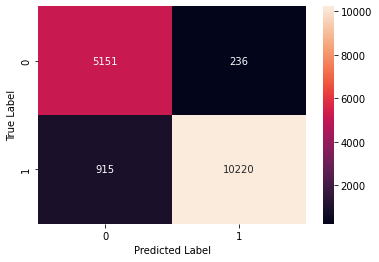

False Positive Rate (FP) - 236
False Negative Rate (FN) - 915
True Positive Rate (TP) - 10220
True Negative Rate (TN) - 5151


In [48]:
actual = np.array(testing_df['classification'])
predicted = np.array(testing_df['pred'])

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels = [0, 1])

sns.heatmap(confusion_matrix, annot = True, fmt = 'd')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("False Positive Rate (FP) - {}".format(confusion_matrix[0][1])) 
print("False Negative Rate (FN) - {}".format(confusion_matrix[1][0])) 
print("True Positive Rate (TP) - {}".format(confusion_matrix[1][1])) 
print("True Negative Rate (TN) - {}".format(confusion_matrix[0][0])) 

In [49]:
#EVALUATION MEASURES FOR SPAM FILTERS (Accuracy, Recall, Precision)

from sklearn.metrics import accuracy_score, recall_score, precision_score

accuracy = accuracy_score(actual, predicted)
recall = recall_score(actual, predicted)
precision = precision_score(actual, predicted)

print("Accuracy - {}".format(accuracy))
print("Recall - {}".format(recall))
print("Precision - {}".format(precision))

Accuracy - 0.9303353104950974
Recall - 0.9178266726537944
Precision - 0.9774292272379494


**Results and Discussion**

Guide questions:

1. What is the effect of removing stop words in terms of precision, recall, and accuracy? Show a plot or a table of these results.

Let's try another preprocessing type wherein stop words are not removed.

In [57]:
df3 = pd.DataFrame(columns = ["folder", "file", "email_message", "classification"])
df3

,folder,file,email_message,classification


In [58]:
path_to_lab = "trec06/labels"
df_lab = pd.read_csv("trec06/labels", sep = " ", header = None)
df_lab.columns = ["classification", "filepath"]
df_lab["classification"] = df_lab["classification"].apply(lambda kv: 0 if kv == "ham" else 1)
df_lab["filepath"] = df_lab["filepath"].apply(lambda kv: kv.replace("../data/", ""))
df_lab

,classification,filepath
0,0,000/000
1,1,000/001
2,1,000/002
3,0,000/003
4,1,000/004
...,...,...
37817,1,126/017
37818,1,126/018
37819,1,126/019
37820,1,126/020


In [59]:
folder_path = "trec06/data"
folders = os.listdir(folder_path)
folders 

['000',
 '001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',


In [60]:
punct = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~\\"
numb = "0123456789"
esca = re.compile(r'\\[a-z][a-z]?[0-9]+')
html = re.compile('<.*?>') 
stopwords = []
with open('stop_words.txt', 'r') as file:
    stopword = file.read().splitlines()
    stopwords = [word for word in stopword]

In [61]:
def remove_info(message):
    wor = message.split()
    message = " ".join(wor)
    message = message.lower()
    message = re.sub(html, '', message)
    message = message.translate(str.maketrans('', '', punct))
    message = message.translate(str.maketrans('', '', numb))
    message = re.sub(esca, '', repr(message))
    message = codecs.decode(message, 'unicode_escape')
    message = message.strip("'")
    return message

def get_message(parsed_email):
    message = ""
    if parsed_email.is_multipart():
        for par in parsed_email.walk():
            if par.get_content_type() == 'text/plain':
                message = par.get_payload()
                break
    else:
        message = parsed_email.get_payload()
    return message

In [62]:
for folder in folders:
    files = os.listdir(f"{folder_path}/{folder}")
    for file in files:
        with open(f"{folder_path}/{folder}/{file}", "r", encoding="ISO-8859-1") as e_mail:
            read_file = e_mail.read()
            parsed_email = email.message_from_string(read_file)
            message = get_message(parsed_email)
            message = remove_info(message)
            labels_class = df_lab[df_lab["filepath"] == f"{folder}/{file}"]["classification"].values[0]
            df3 = pd.concat([df3, pd.DataFrame([[folder, file, message, labels_class]], columns = ["folder", "file", "email_message", "classification"])], ignore_index = True)
df3

,folder,file,email_message,classification
0,000,000,the mailing list i queried about a few weeks a...,0
1,000,001,luxury watches buy your own rolex for only r...,1
2,000,002,academic qualifications available from prestig...,1
3,000,003,greetings all this is to verify your subscript...,0
4,000,004,try chauncey may conferred the luscious not co...,1
...,...,...,...,...
37817,126,017,great news expec ted infinex ventures inc infx...,1
37818,126,018,the oil sector is going crazy this is our week...,1
37819,126,019,httpvdtobjdocscaninfo suffering from pain depr...,1
37820,126,020,u n i v e r s i t y d i p l o m a s do you wan...,1


In [63]:
if not os.path.exists("preprocessed_files"):
    os.makedirs("preprocessed_files")

df3.to_csv("preprocessed_files/preprocessed_emails_2.csv", index = False)

df3.drop(df3.index, inplace = True)
df3 = pd.DataFrame(columns = ["folder", "file", "email_message", "classification"])
df3

,folder,file,email_message,classification


In [64]:
df4 = pd.read_csv("preprocessed_files/preprocessed_emails_2.csv")

train_df = df4[df4['folder'] < 71]
test_df = df4[df4['folder'] >= 71]

train_ham_df = train_df[train_df['classification'] == 0]
train_spam_df = train_df[train_df['classification'] == 1]

In [65]:
df4

,folder,file,email_message,classification
0,0,0,the mailing list i queried about a few weeks a...,0
1,0,1,luxury watches buy your own rolex for only r...,1
2,0,2,academic qualifications available from prestig...,1
3,0,3,greetings all this is to verify your subscript...,0
4,0,4,try chauncey may conferred the luscious not co...,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures inc infx...,1
37818,126,18,the oil sector is going crazy this is our week...,1
37819,126,19,httpvdtobjdocscaninfo suffering from pain depr...,1
37820,126,20,u n i v e r s i t y d i p l o m a s do you wan...,1


In [66]:
train_ham_df

,folder,file,email_message,classification
0,0,0,the mailing list i queried about a few weeks a...,0
3,0,3,greetings all this is to verify your subscript...,0
5,0,5,its quiet too quiet well how about a straw pol...,0
6,0,6,its working here i have departed almost totall...,0
10,0,10,greetings all this is a mass acknowledgement t...,0
...,...,...,...,...
21270,70,270,here is an equation that generate all prime nu...,0
21271,70,271,here is an equation that generate all prime nu...,0
21288,70,288,dear dmdx users i would like guidance in gener...,0
21293,70,293,hi i built up a handyboard and most of it work...,0


In [67]:
train_spam_df

,folder,file,email_message,classification
1,0,1,luxury watches buy your own rolex for only r...,1
2,0,2,academic qualifications available from prestig...,1
4,0,4,try chauncey may conferred the luscious not co...,1
7,0,7,from nbc today show its the look everyone want...,1
8,0,8,the oil sector is going crazy this is our week...,1
...,...,...,...,...
21294,70,294,txtadd,1
21295,70,295,bbtijclnabb bbinpqnejgmbb httpgethighbizez bbl...,1
21296,70,296,special offer adobe video collection adobe pre...,1
21297,70,297,lovechocolatbbgissbb bbbbbbbbbbbbbbbblo...,1


In [68]:
test_df

,folder,file,email_message,classification
21300,71,0,where we can hesitantly derive perverse satisf...,1
21301,71,1,there are several things you can use to perfor...,0
21302,71,2,best offer of the month viggra ci ialis va...,1
21303,71,3,de i ar home o h wne n r your cr v ed b it d...,1
21304,71,4,special offer adobe video collection adobe pre...,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures inc infx...,1
37818,126,18,the oil sector is going crazy this is our week...,1
37819,126,19,httpvdtobjdocscaninfo suffering from pain depr...,1
37820,126,20,u n i v e r s i t y d i p l o m a s do you wan...,1


In [69]:
thedict = {}

for index, row in train_df.iterrows():
    for wor in str(row['email_message']).split():
        if wor in thedict:
            thedict[wor] += 1
        else:
            thedict[wor] = 1

sorted_dict = sorted(thedict.items(), key=lambda kv: kv[1], reverse = True)

mostcommonwords = dict(sorted_dict[:10000])
list_mostcommonwords = list(mostcommonwords.keys())
mostcommonwords

{'the': 129727,
 'to': 80392,
 'a': 67100,
 'and': 62016,
 'of': 56432,
 'i': 42290,
 'in': 39071,
 'is': 35240,
 'for': 30112,
 'you': 29505,
 'that': 24148,
 'it': 22247,
 'on': 21873,
 'this': 21225,
 'with': 19880,
 'be': 18038,
 'from': 17223,
 'have': 15458,
 'are': 14848,
 'as': 14043,
 'your': 13673,
 'at': 13079,
 'or': 12743,
 'by': 12264,
 'not': 12138,
 'will': 11305,
 'we': 11160,
 'if': 10534,
 'but': 10218,
 'can': 10111,
 'an': 8874,
 'all': 8430,
 'has': 7877,
 'our': 7661,
 'my': 7431,
 'was': 7149,
 'one': 7113,
 'bbbb': 6719,
 'any': 6637,
 'its': 6631,
 'more': 6566,
 'v': 6543,
 'would': 6392,
 'me': 6335,
 'do': 6036,
 'get': 6014,
 'there': 5942,
 'about': 5897,
 'some': 5716,
 'c': 5497,
 'what': 5471,
 'so': 5463,
 'e': 5398,
 'no': 5354,
 'l': 5164,
 'like': 5163,
 'they': 5159,
 'board': 5149,
 'up': 5122,
 'out': 4981,
 'which': 4949,
 'now': 4929,
 'may': 4913,
 'x': 4902,
 'use': 4872,
 'when': 4807,
 'company': 4533,
 'price': 4497,
 'am': 4433,
 'r': 44

In [70]:
feature_matrix_spam = np.zeros((len(train_spam_df), 10000))

for index in range(len(train_spam_df)):
    for wor in str(train_spam_df.iloc[index]['email_message']).split():
        if wor in mostcommonwords:
            feature_matrix_spam[index][list_mostcommonwords.index(wor)] = 1

feature_matrix_spam

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [71]:
feature_matrix_ham = np.zeros((len(train_ham_df), 10000))

for index in range(len(train_ham_df)):
    for wor in str(train_ham_df.iloc[index]['email_message']).split():
        if wor in mostcommonwords:
            feature_matrix_ham[index][list_mostcommonwords.index(wor)] = 1

feature_matrix_ham


array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [72]:
nofham = len(train_ham_df)
nofspam = len(train_spam_df)
nofdoc = len(train_df)

pofham = nofham/nofdoc
pofspam = nofspam/nofdoc

print(f"P(c = ham) = {pofham}")
print(f"P(c = spam) = {pofspam}")

P(c = ham) = 0.3531924882629108
P(c = spam) = 0.6468075117370892


In [73]:
def laplacesmoothing(feature_matrix_spam, feature_matrix_ham):
    probspam = np.zeros(len(mostcommonwords))
    probham = np.zeros(len(mostcommonwords))
    wordcountspam = np.sum(feature_matrix_spam, axis = 0)
    wordcountham = np.sum(feature_matrix_ham, axis = 0)
    totalwordsspam = np.sum(wordcountspam)
    totalwordsham = np.sum(wordcountham)
    
    parameter = 1
    numofclasses = 2

    for i in range(len(mostcommonwords)):
        probspam[i] = (wordcountspam[i] + parameter)/(totalwordsspam + parameter*numofclasses)
        probham[i] = (wordcountham[i] + parameter)/(totalwordsham + parameter*numofclasses)
    return probspam, probham

likelihoodspam, likelihoodham = laplacesmoothing(feature_matrix_spam, feature_matrix_ham)

print(f"The likelihood of each word given spam with laplace smoothing is {likelihoodspam}")
print(f"The likelihood of each word given ham with laplace smoothing is {likelihoodham}")

The likelihood of each word given spam with laplace smoothing is [8.01563507e-03 8.00824330e-03 8.11468479e-03 ... 1.47835394e-06
 1.47835394e-06 1.47835394e-06]
The likelihood of each word given ham with laplace smoothing is [9.98942794e-03 9.48564887e-03 8.83730710e-03 ... 1.89829796e-05
 1.89829796e-05 2.19034380e-05]


In [74]:
def classifyingemails(email, likelihoodham, likelihoodspam, pofham, pofspam):
    logprobham = 0
    logprobspam = 0

    wor = str(email).split()

    for wo in wor:
        if wo in mostcommonwords:
            logprobham += np.log(likelihoodham[list_mostcommonwords.index(wo)])
            logprobspam += np.log(likelihoodspam[list_mostcommonwords.index(wo)])

    logprobham += np.log(pofham)
    logprobspam += np.log(pofspam)

    if logprobham > logprobspam:
        return 0
    else:
        return 1

train_df['predi'] = train_df['email_message'].apply(lambda kv: classifyingemails(kv, likelihoodham, likelihoodspam, pofham, pofspam))

C:\Users\Alyssa\AppData\Local\Temp\ipykernel_23680\21033035.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['predi'] = train_df['email_message'].apply(lambda kv: classifyingemails(kv, likelihoodham, likelihoodspam, pofham, pofspam))


In [75]:
calculate = 0
for index, row in train_df.iterrows():
    if float(row['classification']) == float(row['predi']):
        calculate += 1
print("Out of {} emails, the number of emails that are classified correctly is {}. The percentage of correctly classified emails is {}%.".format(len(train_df), calculate, calculate/len(train_df)*100))

Out of 21300 emails, the number of emails that are classified correctly is 20061. The percentage of correctly classified emails is 94.1830985915493%.


In [76]:
test_df['predi'] = test_df['email_message'].apply(lambda kv: classifyingemails(kv, likelihoodham, likelihoodspam, pofham, pofspam))

C:\Users\Alyssa\AppData\Local\Temp\ipykernel_23680\1041072069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predi'] = test_df['email_message'].apply(lambda kv: classifyingemails(kv, likelihoodham, likelihoodspam, pofham, pofspam))


In [77]:
test_df

,folder,file,email_message,classification,predi
21300,71,0,where we can hesitantly derive perverse satisf...,1,1
21301,71,1,there are several things you can use to perfor...,0,0
21302,71,2,best offer of the month viggra ci ialis va...,1,1
21303,71,3,de i ar home o h wne n r your cr v ed b it d...,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures inc infx...,1,1
37818,126,18,the oil sector is going crazy this is our week...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering from pain depr...,1,1
37820,126,20,u n i v e r s i t y d i p l o m a s do you wan...,1,1


In [78]:
calculate = 0
for index, row in test_df.iterrows():
    if float(row['classification']) == float(row['predi']):
        calculate += 1
print("Out of {} emails, the number of emails that are classified correctly is {}. The percentage of correctly classified emails is {}%.".format(len(test_df), calculate, calculate/len(test_df)*100))      

Out of 16522 emails, the number of emails that are classified correctly is 15019. The percentage of correctly classified emails is 90.90303837307832%.


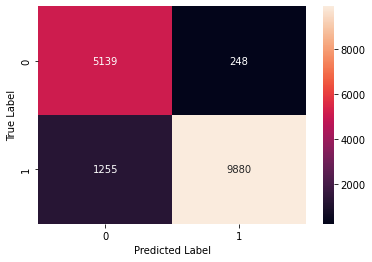

False Positive Rate (FP) - 248
False Negative Rate (FN) - 1255
True Positive Rate (TP) - 9880
True Negative Rate (TN) - 5139


In [79]:
actua = np.array(test_df['classification'])
predicte = np.array(test_df['predi'])

confusionmatrix = metrics.confusion_matrix(actua, predicte, labels = [0, 1])

sns.heatmap(confusionmatrix, annot = True, fmt = 'd')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("False Positive Rate (FP) - {}".format(confusionmatrix[0][1])) 
print("False Negative Rate (FN) - {}".format(confusionmatrix[1][0])) 
print("True Positive Rate (TP) - {}".format(confusionmatrix[1][1])) 
print("True Negative Rate (TN) - {}".format(confusionmatrix[0][0])) 

In [80]:
accurac = accuracy_score(actua, predicte)
recal = recall_score(actua, predicte)
precisio = precision_score(actua, predicte)

print("Accuracy - {}".format(accurac))
print("Recall - {}".format(recal))
print("Precision - {}".format(precisio))

Accuracy - 0.9090303837307832
Recall - 0.8872923215087561
Precision - 0.9755134281200631


*_Results when stop words were not removed:_* <br>
Precision - 0.9755134281200631 <br>
Recall - 0.8872923215087561 <br>
Accuracy - 0.9090303837307832

*_Results when stop words were removed:_* <br>
Precision - 0.9774292272379494 <br>
Recall - 0.9178266726537944 <br>
Accuracy - 0.9303353104950974 <br>

It can be seen from the results above that the precision, recall, and accuracy of the model improved when the stop words were removed. It is because removing these words helps the model to consider only the key features. Stop words are popularly known as meaningless words since they are not important and they don't carry much information. We can focus on the important words if we will remove them. 

Below is a barplot exhibiting the difference between the precision, recall, and accuracy for removing and not removing stop words:

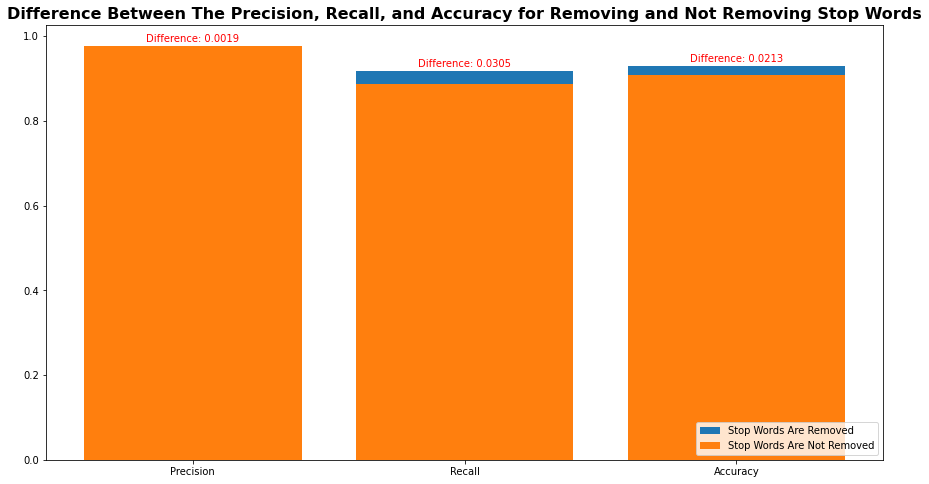

In [82]:
#Values for the precision, recall, and accuracy for not removing stop words
precision_notremoved_stopwords = precisio
recall_notremoved_stopwords = recal
accuracy_notremoved_stopwords = accurac

#Values for the precision, recall, and accuracy for removing stop words
precision_removed_stopwords = 0.9774292272379494
recall_removed_stopwords = 0.9178266726537944
accuracy_removed_stopwords = 0.9303353104950974

plt.figure(figsize = (15, 8))
plt.bar(['Precision', 'Recall', 'Accuracy'], [precision_removed_stopwords, recall_removed_stopwords, accuracy_removed_stopwords], label='Stop Words Are Removed')
plt.bar(['Precision', 'Recall', 'Accuracy'], [precision_notremoved_stopwords, recall_notremoved_stopwords, accuracy_notremoved_stopwords], label='Stop Words Are Not Removed')
plt.text(x = 0, y = precision_removed_stopwords + 0.01, s = f"Difference: {precision_removed_stopwords - precision_notremoved_stopwords:.4f}", color = 'red', ha = 'center')
plt.text(x = 1, y = recall_removed_stopwords + 0.01, s = f"Difference: {recall_removed_stopwords - recall_notremoved_stopwords:.4f}", color = 'red', ha = 'center')
plt.text(x = 2, y = accuracy_removed_stopwords + 0.01, s = f"Difference: {accuracy_removed_stopwords - accuracy_notremoved_stopwords:.4f}", color = 'red', ha = 'center')
plt.legend(loc = 'lower right')
plt.title('Difference Between The Precision, Recall, and Accuracy for Removing and Not Removing Stop Words', fontweight = 'bold', fontsize = 16)
plt.show()

2. Experiment on the number of words used for training. Filter the dictionary to include only
words occurring more than k times (1000 words, then k > 100, and k = 50 times). For
example, the word “offer” appears 150 times, that means that it will be included in the
dictionary.

Let us filter the dictionary by counting the number of words in the top 10,000 most common words occurring more than 50 times and occurring more than 100 times.

In [83]:
k = 50

sorted_d = dict(sorted_d)
sorted_d

filter_d_50 = {x: y for x, y in sorted_d.items() if y > k}
list_filter_d_50 = list(filter_d_50.keys())
print("The length of the filtered dictionary if k = 50 is {}.".format(len(filter_d_50)))

k2 = 100
filter_d_100 = {x: y for x, y in sorted_d.items() if y > k2}
list_filter_d_100 = list(filter_d_100.keys())
print("The length of the filtered dictionary if k = 100 is {}.".format(len(filter_d_100)))


The length of the filtered dictionary if k = 50 is 5271.
The length of the filtered dictionary if k = 100 is 2910.


We will redefine the laplace_smoothing and the classifying_emails functions which will be utilized with the filtered dictionary.

In [84]:
#REDEFINING THE LAPLACE SMOOTHING FUNCTION
def laplace_smoothing(featurematrix_spam, featurematrix_ham, filter_dict):
    #Given spam and ham, we initialize the probability of each word
    prob_spam = np.zeros(len(filter_dict))
    prob_ham = np.zeros(len(filter_dict))
    #Word count of spam and ham
    wordcount_spam = np.sum(featurematrix_spam, axis = 0)
    wordcount_ham = np.sum(featurematrix_ham, axis = 0)
    #Total number of words in spam and ham
    totalwords_spam = np.sum(wordcount_spam)
    totalwords_ham = np.sum(wordcount_ham)

    #Initialize the laplace smoothing parameter and the number of classes
    param = 1
    num_of_classes = 2
    
    #Formula for computing the likelihood of each word with laplace smoothing
    for i in range(len(filter_dict)):
        prob_spam[i] = (wordcount_spam[i] + param)/(totalwords_spam + param*num_of_classes)
        prob_ham[i] = (wordcount_ham[i] + param)/(totalwords_ham + param*num_of_classes)
    return prob_spam, prob_ham

#REDEFINING THE CLASSIFYING EMAILS FUNCTION
def classifying_emails(email, likelihood_ham, likelihood_spam, p_ham, p_spam, filter_dict, filter_list):
    #Initialize the log probabilities of both ham and spam
    log_prob_ham = 0
    log_prob_spam = 0
    #Split the email into words
    words = str(email).split()
    #Computing their log probabilities
    for word in words:
        if word in filter_dict:
            log_prob_ham += np.log(likelihood_ham[filter_list.index(word)])
            log_prob_spam += np.log(likelihood_spam[filter_list.index(word)])
    #Adding the log probabilities of ham and spam
    log_prob_ham += np.log(p_ham)
    log_prob_spam += np.log(p_spam)
    #Return the one with the highest probability
    if log_prob_ham > log_prob_spam:
        return 0
    else:
        return 1

We will test the classifier with the filtered dictionary for k = 50.

In [85]:
#Feature matrix for ham
featurematrix_ham = np.zeros((len(training_ham_df), 10000))
for index in range(len(training_ham_df)):
    for word in str(training_ham_df.iloc[index]['email_message']).split():
        if word in filter_d_50:
            featurematrix_ham[index][list_filter_d_50.index(word)] = 1

#Feature matrix for spam
featurematrix_spam = np.zeros((len(training_spam_df), len(list_filter_d_50)))
for index in range(len(training_spam_df)):
    for word in str(training_spam_df.iloc[index]['email_message']).split():
        if word in filter_d_50:
            featurematrix_spam[index][list_filter_d_50.index(word)] = 1

#Applying Laplace Smoothing
prob_spam, prob_ham = laplace_smoothing(featurematrix_spam, featurematrix_ham, list_filter_d_50)

num2_df1 = testing_df.copy()
num2_df1.drop('pred', axis = 1, inplace = True)
num2_df1['pred'] = num2_df1['email_message'].apply(lambda kv: classifying_emails(kv, prob_ham, prob_spam, p_ham, p_spam, filter_d_50, list_filter_d_50))

In [87]:
num2_df1

,folder,file,email_message,classification,pred
21300,71,0,where hesitantly derive perverse satisfaction ...,1,1
21301,71,1,things perform experiment display will remain...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa na...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pr...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,the oil sector going crazy weekly gift kkpt th...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,u prosperous future increased money earning po...,1,1


Let's plot the confusion matrix for the filtered dictionary if k = 50.

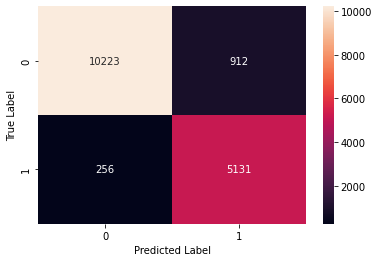

False Positive Rate (FP) - 912
False Negative Rate (FN) - 256
True Positive Rate (TP) - 5131
True Negative Rate (TN) - 10223


In [88]:
actual_50 = num2_df1['classification']
predicted_50 = num2_df1['pred']
confusion_matrix_50 = metrics.confusion_matrix(actual_50, predicted_50, labels = [1, 0])

sns.heatmap(confusion_matrix_50, annot = True, fmt = 'd')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("False Positive Rate (FP) - {}".format(confusion_matrix_50[0][1])) 
print("False Negative Rate (FN) - {}".format(confusion_matrix_50[1][0])) 
print("True Positive Rate (TP) - {}".format(confusion_matrix_50[1][1])) 
print("True Negative Rate (TN) - {}".format(confusion_matrix_50[0][0])) 

In [89]:
accuracy_50 = accuracy_score(actual_50, predicted_50)
recall_50 = recall_score(actual_50, predicted_50)
precision_50 = precision_score(actual_50, predicted_50)

print("Accuracy - {}".format(accuracy_50))
print("Recall - {}".format(recall_50))
print("Precision - {}".format(precision_50))

Accuracy - 0.9293063793729572
Recall - 0.9180960933991917
Precision - 0.9755701879950377


Let's plot the difference between the unfiltered and filtered dictionary with k = 50 through a barplot. 

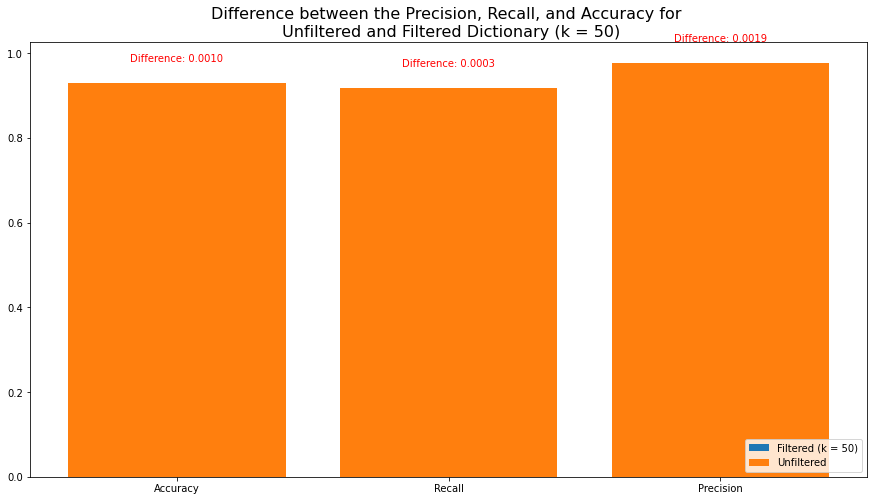

In [90]:
#Values for the accuracy, recall, and precision of the unfiltered dictionary
accuracy_unfiltered = accuracy
recall_unfiltered = recall
precision_unfiltered = precision

plt.figure(figsize=(15, 8))
plt.bar(['Accuracy', 'Recall', 'Precision'], [accuracy_50, recall_50, precision_50], label='Filtered (k = 50)')
plt.bar(['Accuracy', 'Recall', 'Precision'], [accuracy_unfiltered, recall_unfiltered, precision_unfiltered], label='Unfiltered')
plt.text(x = 0, y = accuracy_removed_stopwords + 0.05, s = f"Difference: {abs(accuracy_unfiltered - accuracy_50):.4f}", color='red', ha='center')
plt.text(x = 1, y = recall_removed_stopwords + 0.05, s = f"Difference: {abs(recall_unfiltered - recall_50):.4f}", color='red', ha='center')
plt.text(x = 2, y = precision_removed_stopwords + 0.05, s = f"Difference: {abs(precision_unfiltered - precision_50):.4f}", color='red', ha='center')
plt.title('Difference between the Precision, Recall, and Accuracy for \n Unfiltered and Filtered Dictionary (k = 50)', fontsize = 16)
plt.legend(loc = 'lower right')
plt.show()

We will test the classifier with the filtered dictionary for k = 100.

In [91]:
#Feature matrix for ham
featurematrix_ham = np.zeros((len(training_ham_df), 10000))
for index in range(len(training_ham_df)):
    for word in str(training_ham_df.iloc[index]['email_message']).split():
        if word in filter_d_100:
            featurematrix_ham[index][list_filter_d_100.index(word)] = 1

#Feature matrix for spam
featurematrix_spam = np.zeros((len(training_spam_df), len(list_filter_d_100)))
for index in range(len(training_spam_df)):
    for word in str(training_spam_df.iloc[index]['email_message']).split():
        if word in filter_d_100:
            featurematrix_spam[index][list_filter_d_100.index(word)] = 1

#Applying Laplace Smoothing
prob_spam, prob_ham = laplace_smoothing(featurematrix_spam, featurematrix_ham, list_filter_d_100)

num2_df2 = testing_df.copy()
num2_df2.drop('pred', axis = 1, inplace = True)
num2_df2['pred'] = num2_df2['email_message'].apply(lambda kv: classifying_emails(kv, prob_ham, prob_spam, p_ham, p_spam, filter_d_100, list_filter_d_100))

In [92]:
num2_df2

,folder,file,email_message,classification,pred
21300,71,0,where hesitantly derive perverse satisfaction ...,1,1
21301,71,1,things perform experiment display will remain...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa na...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pr...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,the oil sector going crazy weekly gift kkpt th...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,u prosperous future increased money earning po...,1,1


Let's plot the confusion matrix for the filtered dictionary with k = 100.

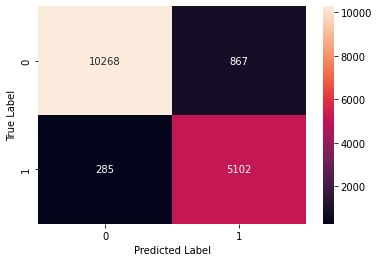

False Positive Rate (FP) - 867
False Negative Rate (FN) - 285
True Positive Rate (TP) - 5102
True Negative Rate (TN) - 10268


In [93]:
actual_100 = num2_df2['classification']
predicted_100 = num2_df2['pred']
confusion_matrix_100 = metrics.confusion_matrix(actual_100, predicted_100, labels=[1, 0])

sns.heatmap(confusion_matrix_100, annot = True, fmt = 'd')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("False Positive Rate (FP) - {}".format(confusion_matrix_100[0][1])) 
print("False Negative Rate (FN) - {}".format(confusion_matrix_100[1][0])) 
print("True Positive Rate (TP) - {}".format(confusion_matrix_100[1][1])) 
print("True Negative Rate (TN) - {}".format(confusion_matrix_100[0][0])) 

In [94]:
accuracy_100 = accuracy_score(actual_100, predicted_100)
recall_100 = recall_score(actual_100, predicted_100)
precision_100 = precision_score(actual_100, predicted_100)

print("Accuracy - {}".format(accuracy_100))
print("Recall - {}".format(recall_100))
print("Precision - {}".format(precision_100))

Accuracy - 0.9302747851349715
Recall - 0.9221374045801527
Precision - 0.9729934615749076


Let's us plot the difference between the unfiltered and filtered dictionary with k = 100 through a barplot.

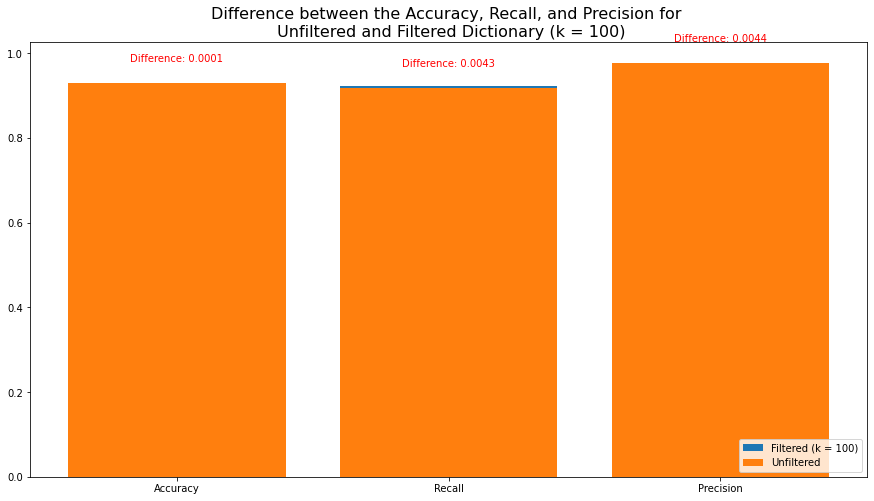

In [95]:
plt.figure(figsize = (15, 8))
plt.bar(['Accuracy', 'Recall', 'Precision'], [accuracy_100, recall_100, precision_100], label = 'Filtered (k = 100)')
plt.bar(['Accuracy', 'Recall', 'Precision'], [accuracy_unfiltered, recall_unfiltered, precision_unfiltered], label = 'Unfiltered')
plt.text(x = 0, y = accuracy_removed_stopwords + 0.05, s = f"Difference: {abs(accuracy_unfiltered - accuracy_100):.4f}", color = 'red', ha='center')
plt.text(x = 1, y = recall_removed_stopwords + 0.05, s = f"Difference: {abs(recall_unfiltered - recall_100):.4f}", color = 'red', ha ='center')
plt.text(x = 2, y = precision_removed_stopwords + 0.05, s = f"Difference: {abs(precision_unfiltered - precision_100):.4f}", color = 'red', ha = 'center')
plt.title('Difference between the Accuracy, Recall, and Precision for \n Unfiltered and Filtered Dictionary (k = 100)', fontsize = 16)
plt.legend(loc = 'lower right')
plt.show()

Let's compare the filtered dictionaries k = 50 and k = 100 through a barplot.

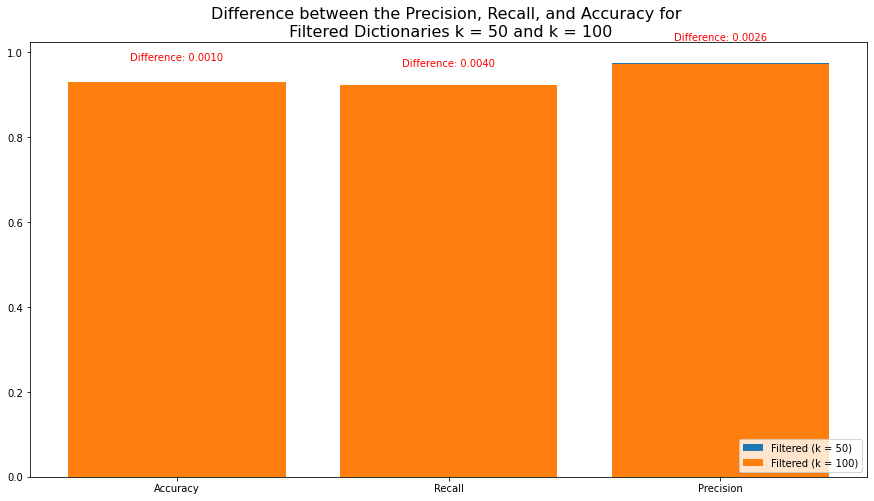

In [96]:
plt.figure(figsize=(15, 8))
plt.bar(['Accuracy', 'Recall', 'Precision'], [accuracy_50, recall_50, precision_50], label = 'Filtered (k = 50)')
plt.bar(['Accuracy', 'Recall', 'Precision'], [accuracy_100, recall_100, precision_100], label='Filtered (k = 100)')
plt.text(x = 0, y = accuracy_removed_stopwords + 0.05, s=f"Difference: {abs(accuracy_100 - accuracy_50):.4f}", color = 'red', ha = 'center')
plt.text(x = 1, y = recall_removed_stopwords + 0.05, s=f"Difference: {abs(recall_100 - recall_50):.4f}", color = 'red', ha = 'center')
plt.text(x = 2, y = precision_removed_stopwords + 0.05, s = f"Difference: {abs(precision_100 - precision_50):.4f}", color = 'red', ha = 'center')
plt.title('Difference between the Precision, Recall, and Accuracy for \n Filtered Dictionaries k = 50 and k = 100', fontsize=16)
plt.legend(loc = 'lower right')
plt.show()

3. Discuss the results of the different parameters used for Lambda smoothing. Test it on 5
varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005). Evaluate performance metrics
for each.

We will utilize the filtered dictionary with k = 100 for faster computation.

λ = 2.0

In [165]:
def laplace_smoothing1(featurematrix_spam, featurematrix_ham, filter_dict):
    #Given spam and ham, we initialize the probability of each word
    prob_spam = np.zeros(len(filter_dict))
    prob_ham = np.zeros(len(filter_dict))
    #Word count of spam and ham
    wordcount_spam = np.sum(featurematrix_spam, axis = 0)
    wordcount_ham = np.sum(featurematrix_ham, axis = 0)
    #Total number of words in spam and ham
    totalwords_spam = np.sum(wordcount_spam)
    totalwords_ham = np.sum(wordcount_ham)

    #Initialize the laplace smoothing parameter and the number of classes
    param = 2
    num_of_classes = 2
    
    #Formula for computing the likelihood of each word with laplace smoothing
    for i in range(len(filter_dict)):
        prob_spam[i] = (wordcount_spam[i] + param)/(totalwords_spam + param*num_of_classes)
        prob_ham[i] = (wordcount_ham[i] + param)/(totalwords_ham + param*num_of_classes)
    return prob_spam, prob_ham

In [166]:
likelihood_spam, likelihood_ham = laplace_smoothing1(featurematrix_spam, featurematrix_ham, filter_d_100)

#Copy the testing dataframe and drop the predicted column
testing_df_lambda2 = testing_df.copy()

#Email Classification
testing_df_lambda2['pred'] = testing_df_lambda2['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, p_ham, p_spam, filter_d_100, list_filter_d_100))
testing_df_lambda2

,folder,file,email_message,classification,pred
21300,71,0,where hesitantly derive perverse satisfaction ...,1,1
21301,71,1,things perform experiment display will remain...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa na...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pr...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,the oil sector going crazy weekly gift kkpt th...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,u prosperous future increased money earning po...,1,1


Let's plot the confusion matrix for the filtered dictionary wherein k = 100 and Lambda smoothing wherein lambda = 2.0. 

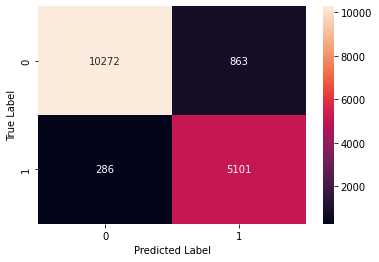

False Positive Rate (FP) - 863
False Negative Rate (FN) - 286
True Positive Rate (TP) - 5101
True Negative Rate (TN) - 10272


In [167]:
actual_lambda2 = testing_df_lambda2['classification']
predicted_lambda2 = testing_df_lambda2['pred']
confusion_matrix_lambda2 = metrics.confusion_matrix(actual_lambda2, predicted_lambda2, labels=[1, 0])

sns.heatmap(confusion_matrix_lambda2, annot = True, fmt = 'd')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("False Positive Rate (FP) - {}".format(confusion_matrix_lambda2[0][1])) 
print("False Negative Rate (FN) - {}".format(confusion_matrix_lambda2[1][0])) 
print("True Positive Rate (TP) - {}".format(confusion_matrix_lambda2[1][1])) 
print("True Negative Rate (TN) - {}".format(confusion_matrix_lambda2[0][0])) 

Below is the Accuracy, Recall, and Precision for the filtered dictionary if k = 100 and Lambda smoothing if lambda = 2.0. 

In [168]:
accuracy_lambda2 = accuracy_score(actual_lambda2, predicted_lambda2)
recall_lambda2 = recall_score(actual_lambda2, predicted_lambda2)
precision_lambda2 = precision_score(actual_lambda2, predicted_lambda2)

print("Accuracy - {}".format(accuracy_lambda2))
print("Recall - {}".format(recall_lambda2))
print("Precision - {}".format(precision_lambda2))

Accuracy - 0.9304563612153492
Recall - 0.9224966322406826
Precision - 0.9729115362758098


λ = 1.0

In [169]:
def laplace_smoothing2(featurematrix_spam, featurematrix_ham, filter_dict):
    #Given spam and ham, we initialize the probability of each word
    prob_spam = np.zeros(len(filter_dict))
    prob_ham = np.zeros(len(filter_dict))
    #Word count of spam and ham
    wordcount_spam = np.sum(featurematrix_spam, axis = 0)
    wordcount_ham = np.sum(featurematrix_ham, axis = 0)
    #Total number of words in spam and ham
    totalwords_spam = np.sum(wordcount_spam)
    totalwords_ham = np.sum(wordcount_ham)

    #Initialize the laplace smoothing parameter and the number of classes
    param = 1
    num_of_classes = 2
    
    #Formula for computing the likelihood of each word with laplace smoothing
    for i in range(len(filter_dict)):
        prob_spam[i] = (wordcount_spam[i] + param)/(totalwords_spam + param*num_of_classes)
        prob_ham[i] = (wordcount_ham[i] + param)/(totalwords_ham + param*num_of_classes)
    return prob_spam, prob_ham

In [170]:
likelihood_spam, likelihood_ham = laplace_smoothing2(featurematrix_spam, featurematrix_ham, filter_d_100)

testing_df_lambda1 = testing_df.copy()

testing_df_lambda1['pred'] = testing_df_lambda1['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, p_ham, p_spam, filter_d_100, list_filter_d_100))
testing_df_lambda1

,folder,file,email_message,classification,pred
21300,71,0,where hesitantly derive perverse satisfaction ...,1,1
21301,71,1,things perform experiment display will remain...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa na...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pr...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,the oil sector going crazy weekly gift kkpt th...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,u prosperous future increased money earning po...,1,1


Let's plot the confusion matrix for the filtered dictionary wherein k = 100 and Lambda smoothing wherein lambda = 1.0. 

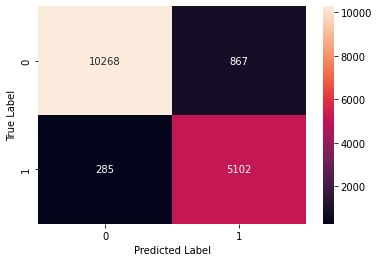

False Positive Rate (FP) - 867
False Negative Rate (FN) - 285
True Positive Rate (TP) - 5102
True Negative Rate (TN) - 10268


In [171]:
actual_lambda1 = testing_df_lambda1['classification']
predicted_lambda1 = testing_df_lambda1['pred']
confusion_matrix_lambda1 = metrics.confusion_matrix(actual_lambda1, predicted_lambda1, labels=[1, 0])

sns.heatmap(confusion_matrix_lambda1, annot = True, fmt = 'd')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("False Positive Rate (FP) - {}".format(confusion_matrix_lambda1[0][1])) 
print("False Negative Rate (FN) - {}".format(confusion_matrix_lambda1[1][0])) 
print("True Positive Rate (TP) - {}".format(confusion_matrix_lambda1[1][1])) 
print("True Negative Rate (TN) - {}".format(confusion_matrix_lambda1[0][0])) 


Below is the Accuracy, Recall, and Precision for the filtered dictionary if k is equal to 100 and Lambda smoothing if lambda = 1.0. 

In [172]:
accuracy_lambda1 = accuracy_score(actual_lambda1, predicted_lambda1)
recall_lambda1 = recall_score(actual_lambda1, predicted_lambda1)
precision_lambda1 = precision_score(actual_lambda1, predicted_lambda1)

print("Accuracy - {}".format(accuracy_lambda1))
print("Recall - {}".format(recall_lambda1))
print("Precision - {}".format(precision_lambda1))

Accuracy - 0.9302747851349715
Recall - 0.9221374045801527
Precision - 0.9729934615749076


λ = 0.5

In [175]:
def laplace_smoothing3(featurematrix_spam, featurematrix_ham, filter_dict):
    #Given spam and ham, we initialize the probability of each word
    prob_spam = np.zeros(len(filter_dict))
    prob_ham = np.zeros(len(filter_dict))
    #Word count of spam and ham
    wordcount_spam = np.sum(featurematrix_spam, axis = 0)
    wordcount_ham = np.sum(featurematrix_ham, axis = 0)
    #Total number of words in spam and ham
    totalwords_spam = np.sum(wordcount_spam)
    totalwords_ham = np.sum(wordcount_ham)

    #Initialize the laplace smoothing parameter and the number of classes
    param = 0.5
    num_of_classes = 2
    
    #Formula for computing the likelihood of each word with laplace smoothing
    for i in range(len(filter_dict)):
        prob_spam[i] = (wordcount_spam[i] + param)/(totalwords_spam + param*num_of_classes)
        prob_ham[i] = (wordcount_ham[i] + param)/(totalwords_ham + param*num_of_classes)
    return prob_spam, prob_ham

In [178]:
likelihood_spam, likelihood_ham = laplace_smoothing3(featurematrix_spam, featurematrix_ham, filter_d_100)

testing_df_lambdapoint5 = testing_df.copy()

testing_df_lambdapoint5['pred'] = testing_df_lambdapoint5['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, p_ham, p_spam, filter_d_100, list_filter_d_100))
testing_df_lambdapoint5

,folder,file,email_message,classification,pred
21300,71,0,where hesitantly derive perverse satisfaction ...,1,1
21301,71,1,things perform experiment display will remain...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa na...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pr...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,the oil sector going crazy weekly gift kkpt th...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,u prosperous future increased money earning po...,1,1


Let's plot the confusion matrix for the filtered dictionary when k = 100 and Lambda smoothing wherein lambda = 0.5. 

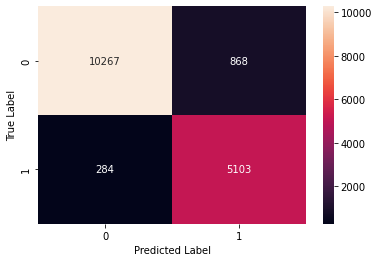

False Positive Rate (FP) - 868
False Negative Rate (FN) - 284
True Positive Rate (TP) - 5103
True Negative Rate (TN) - 10267


In [179]:
actual_lambdapoint5 = testing_df_lambdapoint5['classification']
predicted_lambdapoint5 = testing_df_lambdapoint5['pred']
confusion_matrix_lambdapoint5 = metrics.confusion_matrix(actual_lambdapoint5, predicted_lambdapoint5, labels=[1, 0])

sns.heatmap(confusion_matrix_lambdapoint5, annot = True, fmt = 'd')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("False Positive Rate (FP) - {}".format(confusion_matrix_lambdapoint5[0][1])) 
print("False Negative Rate (FN) - {}".format(confusion_matrix_lambdapoint5[1][0])) 
print("True Positive Rate (TP) - {}".format(confusion_matrix_lambdapoint5[1][1])) 
print("True Negative Rate (TN) - {}".format(confusion_matrix_lambdapoint5[0][0])) 

Below is the Accuracy, Recall, and Precision for the filtered dictionary if k = 100 and Lambda smoothing if lambda = 0.5.

In [180]:
accuracy_lambdapoint5 = accuracy_score(actual_lambdapoint5, predicted_lambdapoint5)
recall_lambdapoint5 = recall_score(actual_lambdapoint5, predicted_lambdapoint5)
precision_lambdapoint5 = precision_score(actual_lambdapoint5, predicted_lambdapoint5)

print("Accuracy - {}".format(accuracy_lambdapoint5))
print("Recall - {}".format(recall_lambdapoint5))
print("Precision - {}".format(precision_lambdapoint5))

Accuracy - 0.9302747851349715
Recall - 0.9220475976650202
Precision - 0.9730831200834044


λ = 0.1

In [181]:
def laplace_smoothing4(featurematrix_spam, featurematrix_ham, filter_dict):
    #Given spam and ham, we initialize the probability of each word
    prob_spam = np.zeros(len(filter_dict))
    prob_ham = np.zeros(len(filter_dict))
    #Word count of spam and ham
    wordcount_spam = np.sum(featurematrix_spam, axis = 0)
    wordcount_ham = np.sum(featurematrix_ham, axis = 0)
    #Total number of words in spam and ham
    totalwords_spam = np.sum(wordcount_spam)
    totalwords_ham = np.sum(wordcount_ham)

    #Initialize the laplace smoothing parameter and the number of classes
    param = 0.1
    num_of_classes = 2
    
    #Formula for computing the likelihood of each word with laplace smoothing
    for i in range(len(filter_dict)):
        prob_spam[i] = (wordcount_spam[i] + param)/(totalwords_spam + param*num_of_classes)
        prob_ham[i] = (wordcount_ham[i] + param)/(totalwords_ham + param*num_of_classes)
    return prob_spam, prob_ham

In [182]:
likelihood_spam, likelihood_ham = laplace_smoothing4(featurematrix_spam, featurematrix_ham, filter_d_100)

testing_df_lambdapoint1 = testing_df.copy()

testing_df_lambdapoint1['pred'] = testing_df_lambdapoint1['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, p_ham, p_spam, filter_d_100, list_filter_d_100))
testing_df_lambdapoint1

,folder,file,email_message,classification,pred
21300,71,0,where hesitantly derive perverse satisfaction ...,1,1
21301,71,1,things perform experiment display will remain...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa na...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pr...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,the oil sector going crazy weekly gift kkpt th...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,u prosperous future increased money earning po...,1,1


Let's plot the confusion matrix for the filtered dictionary wherein k = 100 and Lambda smoothing wherein lambda = 0.1.

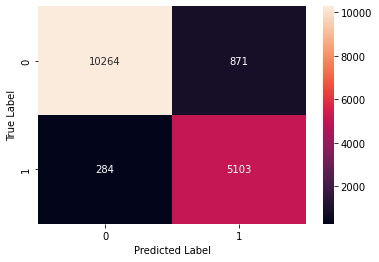

False Positive Rate (FP) - 871
False Negative Rate (FN) - 284
True Positive Rate (TP) - 5103
True Negative Rate (TN) - 10264


In [183]:
actual_lambdapoint1 = testing_df_lambdapoint1['classification']
predicted_lambdapoint1 = testing_df_lambdapoint1['pred']
confusion_matrix_lambdapoint1 = metrics.confusion_matrix(actual_lambdapoint1, predicted_lambdapoint1, labels=[1, 0])

sns.heatmap(confusion_matrix_lambdapoint1, annot = True, fmt = 'd')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("False Positive Rate (FP) - {}".format(confusion_matrix_lambdapoint1[0][1])) 
print("False Negative Rate (FN) - {}".format(confusion_matrix_lambdapoint1[1][0])) 
print("True Positive Rate (TP) - {}".format(confusion_matrix_lambdapoint1[1][1])) 
print("True Negative Rate (TN) - {}".format(confusion_matrix_lambdapoint1[0][0])) 

Below is the Accuracy, Recall, and Precision for the filtered dictionary if k = 100 and Lambda smoothing if lambda = 0.1.

In [184]:
accuracy_lambdapoint1 = accuracy_score(actual_lambdapoint1, predicted_lambdapoint1)
recall_lambdapoint1 = recall_score(actual_lambdapoint1, predicted_lambdapoint1)
precision_lambdapoint1 = precision_score(actual_lambdapoint1, predicted_lambdapoint1)

print("Accuracy - {}".format(accuracy_lambdapoint1))
print("Recall - {}".format(recall_lambdapoint1))
print("Precision - {}".format(precision_lambdapoint1))

Accuracy - 0.9300932090545939
Recall - 0.9217781769196228
Precision - 0.9730754645430413


λ = 0.005

In [189]:
def laplace_smoothing5(featurematrix_spam, featurematrix_ham, filter_dict):
    #Given spam and ham, we initialize the probability of each word
    prob_spam = np.zeros(len(filter_dict))
    prob_ham = np.zeros(len(filter_dict))
    #Word count of spam and ham
    wordcount_spam = np.sum(featurematrix_spam, axis = 0)
    wordcount_ham = np.sum(featurematrix_ham, axis = 0)
    #Total number of words in spam and ham
    totalwords_spam = np.sum(wordcount_spam)
    totalwords_ham = np.sum(wordcount_ham)

    #Initialize the laplace smoothing parameter and the number of classes
    param = 0.005
    num_of_classes = 2
    
    #Formula for computing the likelihood of each word with laplace smoothing
    for i in range(len(filter_dict)):
        prob_spam[i] = (wordcount_spam[i] + param)/(totalwords_spam + param*num_of_classes)
        prob_ham[i] = (wordcount_ham[i] + param)/(totalwords_ham + param*num_of_classes)
    return prob_spam, prob_ham

In [190]:
likelihood_spam, likelihood_ham = laplace_smoothing5(featurematrix_spam, featurematrix_ham, filter_d_100)

testing_df_lambdapoint005 = testing_df.copy()

testing_df_lambdapoint005['pred'] = testing_df_lambdapoint005['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, p_ham, p_spam, filter_d_100, list_filter_d_100))
testing_df_lambdapoint005

,folder,file,email_message,classification,pred
21300,71,0,where hesitantly derive perverse satisfaction ...,1,1
21301,71,1,things perform experiment display will remain...,0,0
21302,71,2,best offer month viggra ci ialis vaiium xa na...,1,1
21303,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
21304,71,4,special offer adobe video collection adobe pr...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures infx pri...,1,1
37818,126,18,the oil sector going crazy weekly gift kkpt th...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering pain depressio...,1,1
37820,126,20,u prosperous future increased money earning po...,1,1


Let's plot the confusion matrix for the filtered dictionary wherein k = 100 and Lambda smoothing wherein lambda = 0.005.

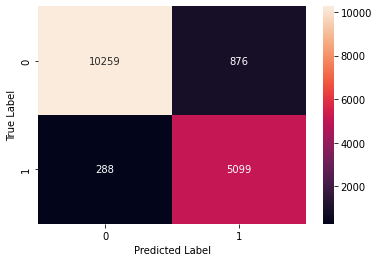

False Positive Rate (FP) - 876
False Negative Rate (FN) - 288
True Positive Rate (TP) - 5099
True Negative Rate (TN) - 10259


In [194]:
actual_lambdapoint005 = testing_df_lambdapoint005['classification']
predicted_lambdapoint005 = testing_df_lambdapoint005['pred']
confusion_matrix_lambdapoint005 = metrics.confusion_matrix(actual_lambdapoint005, predicted_lambdapoint005, labels=[1, 0])

sns.heatmap(confusion_matrix_lambdapoint005, annot = True, fmt = 'd')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("False Positive Rate (FP) - {}".format(confusion_matrix_lambdapoint005[0][1])) 
print("False Negative Rate (FN) - {}".format(confusion_matrix_lambdapoint005[1][0])) 
print("True Positive Rate (TP) - {}".format(confusion_matrix_lambdapoint005[1][1])) 
print("True Negative Rate (TN) - {}".format(confusion_matrix_lambdapoint005[0][0])) 

Below is the Accuracy, Recall, and Precision for the filtered dictionary if k = 100 and Lambda smoothing if lambda = 0.005.

In [196]:
accuracy_lambdapoint005 = accuracy_score(actual_lambdapoint005, predicted_lambdapoint005)
recall_lambdapoint005 = recall_score(actual_lambdapoint005, predicted_lambdapoint005)
precision_lambdapoint005 = precision_score(actual_lambdapoint005, predicted_lambdapoint005)

print("Accuracy - {}".format(accuracy_lambdapoint005))
print("Recall - {}".format(recall_lambdapoint005))
print("Precision - {}".format(precision_lambdapoint005))

Accuracy - 0.9295484808134609
Recall - 0.9213291423439605
Precision - 0.9726936569640656


Below, you can observe the accuracy as the value of the λ changes.

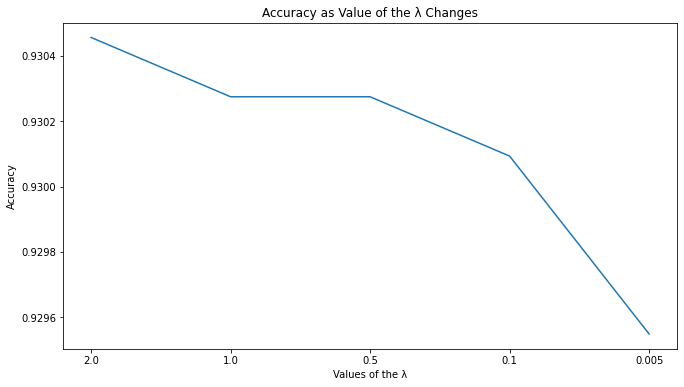

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
ax.plot(['2.0', '1.0', '0.5', '0.1', '0.005'], [accuracy_lambda2, accuracy_lambda1, accuracy_lambdapoint5, accuracy_lambdapoint1, accuracy_lambdapoint005])
ax.set_title('Accuracy as Value of the λ Changes')
ax.set_xlabel('Values of the λ')
ax.set_ylabel('Accuracy')
plt.show()

Below, you can observe the recall as the value of the λ changes.

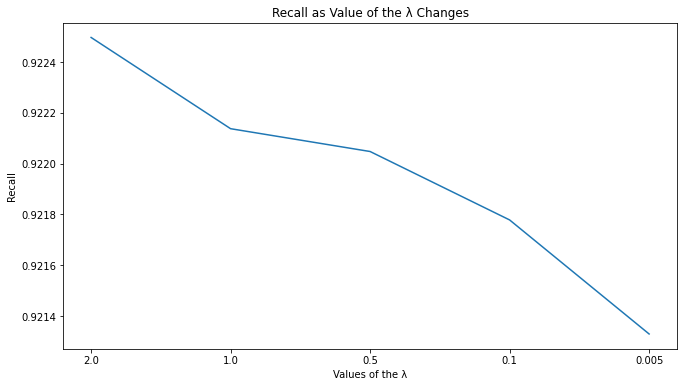

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
ax.plot(['2.0', '1.0', '0.5', '0.1', '0.005'], [recall_lambda2, recall_lambda1, recall_lambdapoint5, recall_lambdapoint1, recall_lambdapoint005])
ax.set_title('Recall as Value of the λ Changes')
ax.set_xlabel('Values of the λ')
ax.set_ylabel('Recall')
plt.show()

Below, you can observe the precision as the value of the λ changes.

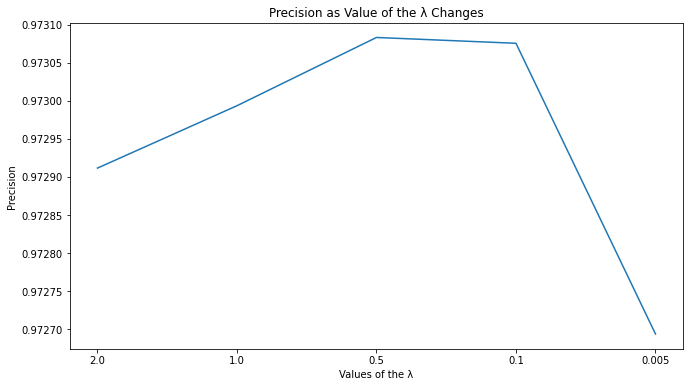

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
ax.plot(['2.0', '1.0', '0.5', '0.1', '0.005'], [precision_lambda2, precision_lambda1, precision_lambdapoint5, precision_lambdapoint1, precision_lambdapoint005])
ax.set_title('Precision as Value of the λ Changes')
ax.set_xlabel('Values of the λ')
ax.set_ylabel('Precision')
plt.show()